## Описание проекта

Необходимо подготовить прототип модели машинного обучения для компании «Цифра». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:
- Подготовить данные;
- Провести исследовательский анализ данных;
- Построить и обучить модель.


### Описание данных

- Rougher feed — исходное сырье

- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant

  -Xanthate **— ксантогенат (промотер, или активатор флотации);
  
  -Sulphate — сульфат (на данном производстве сульфид натрия);
  
  -Depressant — депрессант (силикат натрия).
  
- Rougher process (англ. «грубый процесс») — флотация

- Rougher tails — отвальные хвосты

- Float banks — флотационная установка

- Cleaner process — очистка

- Rougher Au — черновой концентрат золота

- Final Au — финальный концентрат золота

Параметры этапов

- air amount — объём воздуха

- fluid levels — уровень жидкости

- feed size — размер гранул сырья

- feed rate — скорость подачи

### Наименование признаков

`[этап].[тип_параметра].[название_параметра]`

Пример: `rougher.input.feed_ag`

Возможные значения для блока [этап]:

- rougher — флотация

- primary_cleaner — первичная очистка

- secondary_cleaner — вторичная очистка

- final — финальные характеристики

Возможные значения для блока [тип_параметра]:

- input — параметры сырья

- output — параметры продукта

- state — параметры, характеризующие текущее состояние этапа

- calculation — расчётные характеристики

### План проекта

* 1\. Подготовка даных

    * 1.1\. Открытие и изучение данных.

    * 1.2\. Проверка, что эффективность обогащения рассчитана правильно. Вычисление её на обучающей выборке для признака rougher.output.recovery. Поиск MAE между произведенными расчётами и значением признака. Формулирование выводов.

    * 1.3\. Анализ признаков, недоступных в тестовой выборке. Ответ на вопрос: "Что это за параметры? К какому типу относятся?"

    * 1.4\.Предобработка данных.

* 2\. Анализ данных

    * 2.1\. Просмотр, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Формулирование выводов.

    * 2.2\. Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

    * 2.3\. Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Поиск аномальных значений в суммарном распределении. Если они есть, подумать стоит ли их удалять из обеих выборок. Формулирование выводов и удаление аномалий.

* 3\. Построение модели

    * 3.1\.Создание функции для вычисления итоговой sMAPE.

    * 3.1\.Обучение разных моделей и оценка их качества кросс-валидацией. Выбор лучшей модели и проверка её на тестовой выборке. Формулирование выводов.

## Подготовка данных

### Открытие и изучение данных

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import seaborn as sns 
from scipy import stats as st
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.scorer import make_scorer
import sklearn 
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

#### Обучающая выборка

In [4]:
train_data = pd.read_csv('/datasets/gold_recovery_train.csv')

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


#### Тестовая выборка

In [6]:
test_data = pd.read_csv('/datasets/gold_recovery_test.csv')

In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

#### Исходная выборка

In [8]:
full_data = pd.read_csv('/datasets/gold_recovery_full.csv')

In [9]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


### Проверка правильности расчета эффективности обогащения

In [10]:
[clmn for clmn in train_data.columns if 'rougher' in clmn]

['rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'rougher.output.tail_au',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_l

Напишем функцию для расчета эффективности обогащения

In [11]:
train_data.columns

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

In [12]:
full_data.columns

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

In [13]:
def calc_recovery(row):
    cols = ['rougher.output.concentrate_au','rougher.output.concentrate_ag',\
           'rougher.output.concentrate_pb','rougher.output.concentrate_sol','rougher.input.feed_au']
    #Проверка на нулевые значения
    for col in cols:
        if row[col] == 0:
            return 0
    #доля золота в концентрате после флотации/очистки
    C = row['rougher.output.concentrate_au']
                                              
    #доля золота в сырье/концентрате до флотации/очистки
    F = row['rougher.input.feed_au']
    T = row['rougher.output.tail_au']
    return ((C*(F-T))/(F*(C-T)))*100

In [14]:
train_data['rougher.output.recovery_check'] = train_data.apply(calc_recovery,axis=1)

In [15]:
train_data[['rougher.output.recovery_check','rougher.output.recovery']]

,rougher.output.recovery_check,rougher.output.recovery
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794
...,...,...
16855,89.574376,89.574376
16856,87.724007,87.724007
16857,88.890579,88.890579
16858,89.858126,89.858126


Найдем МАЕ

In [16]:
train_data_for_MAE = train_data[['rougher.output.recovery','rougher.output.recovery_check']].dropna()

In [17]:
mae = mean_absolute_error(train_data_for_MAE['rougher.output.recovery'],train_data_for_MAE['rougher.output.recovery_check'])

In [18]:
print(f'{mae:.2f}')

0.00


Вывод: Ошибки нет

### Анализ признаков недоступных в тестовой выборке

Найдем каких признаков нет в тестовой выборке, но есть в тренировочной

In [19]:
[clmn for clmn in train_data.columns if clmn not in test_data.columns]

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

Все эти признаки относятся к данным, которые мы получаем уже в процессе очистки

### Предобработка данных

#### Удаление пропусков

Удалим все пропуски

In [20]:
train_data.dropna(inplace=True)

In [21]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11017 entries, 0 to 16859
Data columns (total 88 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                11017 non-null  object 
 1   final.output.concentrate_ag                         11017 non-null  float64
 2   final.output.concentrate_pb                         11017 non-null  float64
 3   final.output.concentrate_sol                        11017 non-null  float64
 4   final.output.concentrate_au                         11017 non-null  float64
 5   final.output.recovery                               11017 non-null  float64
 6   final.output.tail_ag                                11017 non-null  float64
 7   final.output.tail_pb                                11017 non-null  float64
 8   final.output.tail_sol                               11017 non-null  float64


#### Удаление 0 значений

Разберемся когда мы получаем 0 значения в целевом признаке

In [22]:
cols = ['rougher.input.feed_au','rougher.input.floatbank10_sulfate','rougher.input.floatbank10_xanthate','rougher.input.feed_sol','rougher.input.feed_pb',\
            'rougher.input.feed_ag','rougher.input.floatbank11_xanthate','rougher.input.floatbank11_sulfate','rougher.output.concentrate_au','rougher.output.concentrate_ag',\
           'rougher.output.concentrate_pb','rougher.output.concentrate_sol']

In [23]:
train_data[train_data['rougher.output.recovery']==0][cols]

,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.feed_sol,rougher.input.feed_pb,rougher.input.feed_ag,rougher.input.floatbank11_xanthate,rougher.input.floatbank11_sulfate,rougher.output.concentrate_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol
45,7.114065,13.322740,7.504592,41.154430,2.811569,7.521974,7.493738,13.311361,0.0,0.0,0.0,0.0
46,7.651522,14.433889,7.583598,41.983063,2.973841,7.313187,7.578460,14.482716,0.0,0.0,0.0,0.0
51,7.039270,12.785794,7.797513,38.010139,2.770323,7.835670,7.799592,12.761515,0.0,0.0,0.0,0.0
52,7.321526,14.027409,7.802530,39.417952,3.073579,8.027547,7.803939,14.013836,0.0,0.0,0.0,0.0
836,11.433690,14.468858,9.517497,34.949583,5.503190,13.850236,9.514789,14.522210,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12273,8.693420,8.653006,5.703463,39.543212,2.674788,10.008169,5.702142,8.654270,0.0,0.0,0.0,0.0
12274,9.406580,9.388084,5.697300,40.013651,3.128491,10.578059,5.700789,9.391906,0.0,0.0,0.0,0.0
12275,9.705671,9.972796,5.714862,39.508597,3.460388,11.027766,5.716795,9.969833,0.0,0.0,0.0,0.0
12288,7.838613,7.640938,5.999460,40.723155,2.430129,9.420538,6.002919,7.640271,0.0,0.0,0.0,0.0


In [24]:
train_data[cols]

,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.feed_sol,rougher.input.feed_pb,rougher.input.feed_ag,rougher.input.floatbank11_xanthate,rougher.input.floatbank11_sulfate,rougher.output.concentrate_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol
0,6.486150,11.986616,6.007990,36.808594,2.284912,6.100378,6.005818,11.836743,19.793808,11.500771,7.101074,28.029297
1,6.478583,11.971193,6.005766,35.753385,2.266033,6.161113,6.012594,11.996163,20.050975,11.615865,7.278807,28.067063
2,6.362222,11.920603,6.197377,35.971630,2.159622,6.116455,6.204633,11.920305,19.737170,11.695753,7.216833,27.454037
3,6.118189,11.630094,6.203177,36.862241,2.037807,6.043309,6.196578,11.692450,19.320810,11.915047,7.175616,27.341277
4,5.663707,10.957755,6.198826,34.347666,1.786875,6.060915,6.194897,10.960521,19.216101,12.411054,7.240205,27.041023
...,...,...,...,...,...,...,...,...,...,...,...,...
16855,5.335862,7.762770,9.158609,37.369774,4.617558,6.091855,9.156069,7.766744,18.603550,11.124896,10.984003,30.068876
16856,4.838619,7.356687,9.304952,38.591551,4.144989,6.121323,9.297924,7.095508,18.441436,11.425983,10.888213,29.783972
16857,4.525061,6.586020,9.299606,40.074026,4.020002,5.970515,9.300133,6.584130,15.111231,8.523497,8.955135,22.786467
16858,4.362781,6.210119,9.297709,39.713906,3.902537,6.048130,9.297194,6.209517,17.834772,11.658799,10.655377,29.052742


Можно сделать вывод, что либо ошибки в данных, либо неудачные попытки очистки. Избавимся от этих значений

In [25]:
train_data = train_data[(train_data['rougher.output.recovery']!=0) & (train_data['final.output.recovery']!=0)]

## Анализ данных

### Анализ изменения концентрации металлов

Посмотрим как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. 

In [26]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


#### Золото

/home/igor/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/igor/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


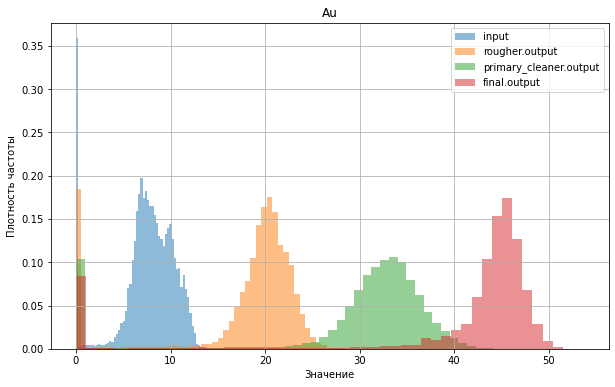

In [27]:
fig, (ax1) = plt.subplots(1,figsize=(10,6))
ax1.hist(full_data['rougher.input.feed_au'],density=True,bins=60,alpha = 0.5,label = 'input')
ax1.grid(True)
ax1.hist(full_data['rougher.output.concentrate_au'],density=True,bins=50,alpha = 0.5,label = 'rougher.output')
ax1.hist(full_data['primary_cleaner.output.concentrate_au'],density=True,bins=50,alpha = 0.5,label = 'primary_cleaner.output')
ax1.hist(full_data['final.output.concentrate_au'],density=True,bins=50,alpha = 0.5,label = 'final.output')
ax1.set_ylabel("Плотность частоты")
ax1.set_xlabel('Значение')
ax1.set_title('Au')
ax1.legend()
plt.show()

#### Свинец

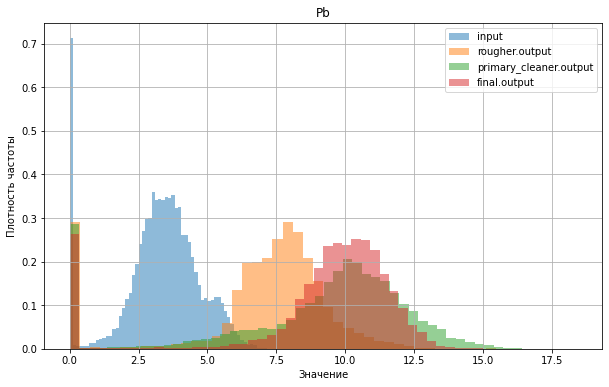

In [28]:
fig, (ax1) = plt.subplots(1,figsize=(10,6))
ax1.hist(full_data['rougher.input.feed_pb'],density=True,bins=60,alpha = 0.5,label = 'input')
ax1.grid(True)
ax1.hist(full_data['rougher.output.concentrate_pb'],density=True,bins=50,alpha = 0.5,label = 'rougher.output')
ax1.hist(full_data['primary_cleaner.output.concentrate_pb'],density=True,bins=50,alpha = 0.5,label = 'primary_cleaner.output')
ax1.hist(full_data['final.output.concentrate_pb'],density=True,bins=50,alpha = 0.5,label = 'final.output')
ax1.set_ylabel("Плотность частоты")
ax1.set_xlabel('Значение')
ax1.set_title('Pb')
ax1.legend()
plt.show()

#### Серебро

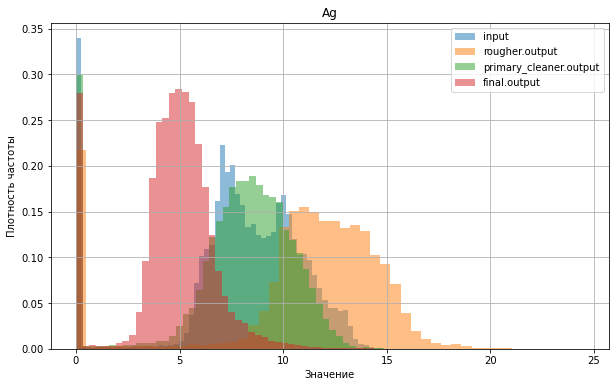

In [29]:
fig, (ax1) = plt.subplots(1,figsize=(10,6))
ax1.hist(full_data['rougher.input.feed_ag'],density=True,bins=60,alpha = 0.5,label = 'input')
ax1.grid(True)
ax1.hist(full_data['rougher.output.concentrate_ag'],density=True,bins=50,alpha = 0.5,label = 'rougher.output')
ax1.hist(full_data['primary_cleaner.output.concentrate_ag'],density=True,bins=50,alpha = 0.5,label = 'primary_cleaner.output')
ax1.hist(full_data['final.output.concentrate_ag'],density=True,bins=50,alpha = 0.5,label = 'final.output')
ax1.set_ylabel("Плотность частоты")
ax1.set_xlabel('Значение')
ax1.set_title('Ag')
ax1.legend()
plt.show()

Вывод: можно предположить что концентрация золота сильно растет с каждым этапом очистки. Концентрация серебра сильно падает с каждым этапом. А концентрация свинца растет после 1 этапа и остается неизменной на следующих

### Сравнение распределения размеров гранул сырья

Сравним для начала среднее значения размеров гранул сырья в обоих выборках

In [30]:
train_data['rougher.input.feed_size'].mean()

57.31586279461973

In [31]:
test_data['rougher.input.feed_size'].mean()

55.93753506406798

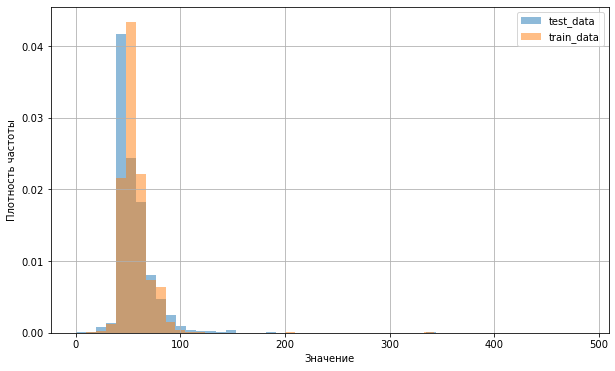

In [32]:
fig, (ax1) = plt.subplots(1,figsize=(10,6))
ax1.hist(test_data['rougher.input.feed_size'],density=True,bins=50,alpha = 0.5,label = 'test_data')
ax1.grid(True)
ax1.hist(train_data['rougher.input.feed_size'],density=True,bins=50,alpha = 0.5,label = 'train_data')
ax1.set_ylabel("Плотность частоты")
ax1.set_xlabel('Значение')
ax1.legend()
plt.show()

Можно сделать вывод, что распределения отличаются незначительно

Посчитаем дисперсии

In [33]:
np.var(train_data['rougher.input.feed_size'])

363.4611923820159

In [34]:
np.var(test_data['rougher.input.feed_size'])

516.3031963423578

Дисперсии отличаются. Учтем это при проверке гипотез

Нулевая гипотеза звучит так: Размеры гранул сырья в обоих выборках одинаковы. 

Альтернативная гипотеза: Размеры гранул сырья в выборках различны

In [35]:
alpha = .05
results = st.ttest_ind(
     train_data['rougher.input.feed_size'], 
     test_data['rougher.input.feed_size'],nan_policy = 'omit',equal_var = False)

print(f'p-значение: {results.pvalue:.20f}')

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.00008114575986303501
Отвергаем нулевую гипотезу


Средние немного отличаются

### Исследование суммарной концентрации 

In [36]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10784 entries, 0 to 16859
Data columns (total 88 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                10784 non-null  object 
 1   final.output.concentrate_ag                         10784 non-null  float64
 2   final.output.concentrate_pb                         10784 non-null  float64
 3   final.output.concentrate_sol                        10784 non-null  float64
 4   final.output.concentrate_au                         10784 non-null  float64
 5   final.output.recovery                               10784 non-null  float64
 6   final.output.tail_ag                                10784 non-null  float64
 7   final.output.tail_pb                                10784 non-null  float64
 8   final.output.tail_sol                               10784 non-null  float64


Введем новые признаки в которых просуммироуем концентрацию всех веществ на каждой стадии

In [37]:
train_data['final.output.concentrate'] = train_data['final.output.concentrate_ag'] +train_data['final.output.concentrate_au']\
+train_data['final.output.concentrate_pb']+train_data['final.output.concentrate_sol']

In [38]:
train_data['primary_cleaner.output.concentrate'] = train_data['primary_cleaner.output.concentrate_ag'] +train_data['final.output.concentrate_au']\
+train_data['primary_cleaner.output.concentrate_pb']+train_data['primary_cleaner.output.concentrate_sol']

In [39]:
train_data['rougher.output.concentrate'] = train_data['rougher.output.concentrate_ag'] +train_data['rougher.output.concentrate_au']\
+train_data['rougher.output.concentrate_pb']+train_data['rougher.output.concentrate_sol']

In [40]:
train_data['rougher.output.concentrate'].describe()

count    10784.000000
mean        69.181170
std          7.975286
min          0.040000
25%         65.753336
50%         69.852369
75%         74.009590
max         87.273435
Name: rougher.output.concentrate, dtype: float64

In [41]:
train_data['primary_cleaner.output.concentrate'].describe()

count    10784.000000
mean        72.592311
std          7.343565
min          5.901388
25%         69.431046
50%         73.385627
75%         77.301683
max         89.861220
Name: primary_cleaner.output.concentrate, dtype: float64

In [42]:
train_data['final.output.concentrate'].describe()

count    10784.000000
mean        69.250053
std          4.777535
min         11.022639
25%         67.910858
50%         69.474586
75%         71.302386
max         80.210644
Name: final.output.concentrate, dtype: float64

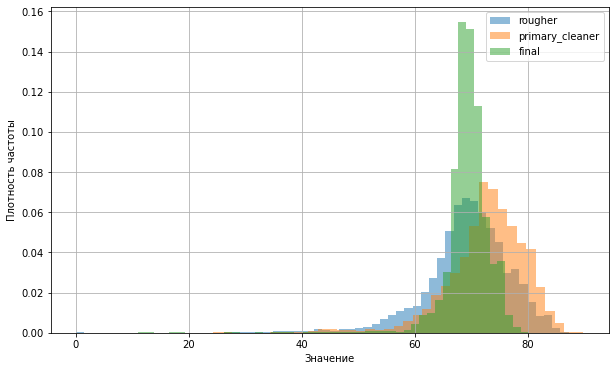

In [43]:
fig, (ax1) = plt.subplots(1,figsize=(10,6))
ax1.hist(train_data['rougher.output.concentrate'],density=True,bins=60,alpha = 0.5,label = 'rougher')
ax1.grid(True)
ax1.hist(train_data['primary_cleaner.output.concentrate'],density=True,bins=50,alpha = 0.5,label = 'primary_cleaner')
ax1.hist(train_data['final.output.concentrate'],density=True,bins=50,alpha = 0.5,label = 'final')
ax1.set_ylabel("Плотность частоты")
ax1.set_xlabel('Значение')
ax1.legend()
plt.show()

Аномальных значений нет. Суммарная концентрация веществ не превышает логически допустимых значений.

## Построение моделей

3.1.Создание функции для вычисления итоговой sMAPE.

3.1.Обучение разных моделей и оценка их качества кросс-валидацией. Выбор лучшей модели и проверка её на тестовой выборке. Формулирование выводов.

### Создание функции для вычисления sMAPE

In [44]:
def smape_calc(target,predict):   
    target = target.to_numpy()

    sum_rougher_final=2*abs(target-predict)/(abs(target)+abs(predict))
    sum_rougher = np.sum(sum_rougher_final,axis=0)[0]
    sum_final = np.sum(sum_rougher_final,axis=0)[1]                                      

    
    smape_rougher=(100/len(target))*sum_rougher
    smape_final = (100/len(target))*sum_final
    
    return 0.25*smape_rougher+0.75*smape_final

### Удаление лишних признаков и подготовка выборок

Для обучения модели мы можем использовать только те признаки, которые есть в тестовой выборке.

In [ ]:
train_data_cut = train_data[test_data.columns]
train_data_cut['rougher.output.recovery'] = train_data['rougher.output.recovery'].copy()
train_data_cut['final.output.recovery'] = train_data['final.output.recovery'].copy()

In [46]:
target_data_cut = train_data_cut[['rougher.output.recovery','final.output.recovery']]

In [47]:
train_data_cut = train_data_cut.drop(['date','rougher.output.recovery','final.output.recovery'],axis=1)

### Обучение моделей

На основе функции написанной ранее создадим scorer

In [48]:
my_scorer = make_scorer(smape_calc)

#### Дерево решений

In [49]:
best_depth = 1
best_DT_model= None
best_result = np.inf
for depth in range(3, 20):
    DT_model = DecisionTreeRegressor(random_state=12345,max_depth=depth)
    result = np.mean(cross_val_score(DT_model, train_data_cut, target_data_cut, cv=3,scoring=my_scorer))
    if best_result>result:
        
        best_result = result
        best_DT_model = DT_model
        best_depth = depth
        
print(f'best score:{best_result:.2f}')
print(f'best depth:{best_depth} ')

best score:8.68
best depth:3 


In [50]:
best_DT_model.fit(train_data_cut,target_data_cut)

DecisionTreeRegressor(max_depth=3, random_state=12345)

Посмотрим какие признаки были важны для предсказания

In [51]:
for a,b in zip(best_DT_model.feature_importances_,train_data_cut.columns):
    print(b,a)

primary_cleaner.input.sulfate 0.0
primary_cleaner.input.depressant 0.0
primary_cleaner.input.feed_size 0.0
primary_cleaner.input.xanthate 0.0
primary_cleaner.state.floatbank8_a_air 0.0
primary_cleaner.state.floatbank8_a_level 0.0
primary_cleaner.state.floatbank8_b_air 0.0
primary_cleaner.state.floatbank8_b_level 0.0
primary_cleaner.state.floatbank8_c_air 0.0
primary_cleaner.state.floatbank8_c_level 0.0
primary_cleaner.state.floatbank8_d_air 0.0
primary_cleaner.state.floatbank8_d_level 0.0
rougher.input.feed_ag 0.5510971433337203
rougher.input.feed_pb 0.0
rougher.input.feed_rate 0.0
rougher.input.feed_size 0.0
rougher.input.feed_sol 0.0
rougher.input.feed_au 0.03401434133383965
rougher.input.floatbank10_sulfate 0.0
rougher.input.floatbank10_xanthate 0.024586009928588476
rougher.input.floatbank11_sulfate 0.0
rougher.input.floatbank11_xanthate 0.0
rougher.state.floatbank10_a_air 0.0
rougher.state.floatbank10_a_level 0.0
rougher.state.floatbank10_b_air 0.0
rougher.state.floatbank10_b_level

Удалим большинство признаков с 0 важностью

In [52]:
imp_features_list = ['rougher.input.feed_ag','rougher.input.feed_pb','rougher.input.feed_size'\
                    ,'rougher.input.feed_au','rougher.input.floatbank10_sulfate','rougher.input.floatbank10_xanthate'\
                    ,'rougher.input.floatbank11_xanthate','rougher.state.floatbank10_f_air'\
                    ,'secondary_cleaner.state.floatbank2_a_air','secondary_cleaner.state.floatbank3_a_level'\
                    ,'secondary_cleaner.state.floatbank3_b_air','secondary_cleaner.state.floatbank4_a_air','secondary_cleaner.state.floatbank5_b_air']
train_data_cut = train_data_cut[imp_features_list]

In [53]:
best_depth = 1
best_DT_model= None
best_result = np.inf
for depth in range(3, 20):
    DT_model = DecisionTreeRegressor(random_state=12345,max_depth=depth)
    result = np.mean(cross_val_score(DT_model, train_data_cut, target_data_cut, cv=3,scoring=my_scorer))
    if best_result>result:
        
        best_result = result
        best_DT_model = DT_model
        best_depth = depth
        
print(f'best score:{best_result:.2f}')
print(f'best depth:{best_depth} ')

best score:8.16
best depth:3 


Попробуем поиграть с параметром max_features 

In [54]:
best_depth = 3
best_DT_model= None
best_result = np.inf
best_max_features = 3
for mf in range(3, len(train_data_cut.columns)):
    DT_model = DecisionTreeRegressor(random_state=12345,max_depth=best_depth,max_features=mf)
    result = np.mean(cross_val_score(DT_model, train_data_cut, target_data_cut, cv=3,scoring=my_scorer))
    if best_result>result:
        best_max_features = mf
        best_result = result
        best_DT_model = DT_model

        
print(f'best score:{best_result:.2f}')
print(f'best depth:{best_depth} ')
print(f'best max_features:{best_max_features}')

best score:7.90
best depth:3 
best max_features:12


In [55]:
best_DT_model.fit(train_data_cut,target_data_cut)

DecisionTreeRegressor(max_depth=3, max_features=12, random_state=12345)

#### Случайный лес

In [57]:
best_RF_model= None
best_result = np.inf
for est in tqdm(range(1, 11)):
    for depth in range(1, 11):
        RF_model = RandomForestRegressor(n_estimators=est,random_state=12345,max_depth=depth)
        result = np.mean(cross_val_score(RF_model, train_data_cut, target_data_cut, cv=3,scoring=my_scorer))
        if best_result>result:
            best_result = result
            best_RF_model = RF_model
            best_depth = depth
            best_est = est
            print(f'new best result {best_result}, est: {best_est}, depth:{best_depth}')
            
print(f'best score:{best_result:.2f}')
print(f'best depth:{best_depth}')
print(f'best est:{best_est}')

new best result 8.072911383335061, est: 1, depth:1
new best result 8.054319081196832, est: 1, depth:2
new best result 7.9664675786413754, est: 1, depth:3



new best result 7.9507226122827275, est: 2, depth:2
new best result 7.922442417027214, est: 2, depth:3



new best result 7.88646103024699, est: 6, depth:2



new best result 7.878631680078129, est: 7, depth:2



new best result 7.8436247888434, est: 9, depth:2





best score:7.84
best depth:2
best est:9


Подберем параметр max_samples и max_features

In [55]:
best_RF_model= None
best_result = np.inf
for mf in range(1, 13):
    for ms in range(100, 2000,100):
            RF_model = RandomForestRegressor(max_samples=ms,max_features=mf,n_estimators=9,random_state=12345,max_depth=2)
            result = np.mean(cross_val_score(RF_model, train_data_cut, target_data_cut, cv=3,scoring=my_scorer))
            if best_result>result:
                best_result = result
                best_RF_model = RF_model
                best_depth = depth
                best_est = est
                best_mf=mf
                best_ms=ms
                print(f'result: {best_result}, best ms:{best_ms},best mf:{best_mf}')
            
print(f'best score:{best_result:.2f}')
print(f'best depth:{best_depth}')
print(f'best est:{best_est}')
print(f'best max features:{best_mf}')
print(f'best max samples:{best_ms}')

result: 8.26223812247405, best ms:100,best mf:1
result: 8.24268015162706, best ms:100,best mf:2
result: 8.238854620125638, best ms:500,best mf:2
result: 8.062608196467703, best ms:600,best mf:2
result: 8.057879252132778, best ms:700,best mf:2
result: 8.005869870594639, best ms:900,best mf:2
result: 7.989211960560326, best ms:1500,best mf:3
result: 7.9066864097928695, best ms:600,best mf:4
result: 7.883417682033003, best ms:700,best mf:4
result: 7.873666093632809, best ms:600,best mf:5
result: 7.8250653421889, best ms:700,best mf:5
result: 7.8087986770912226, best ms:800,best mf:5
result: 7.781424473733377, best ms:900,best mf:5
result: 7.778732937715524, best ms:1100,best mf:5
result: 7.756699135485871, best ms:1500,best mf:6
result: 7.7191714038222825, best ms:800,best mf:7
result: 7.701349292906239, best ms:900,best mf:7
result: 7.653800477518257, best ms:800,best mf:9
result: 7.641932034900233, best ms:800,best mf:10
result: 7.591361389835163, best ms:800,best mf:12
best score:7.59


In [56]:
best_RF_model.fit(train_data_cut,target_data_cut)

RandomForestRegressor(max_depth=2, max_features=12, max_samples=800,
                      n_estimators=9, random_state=12345)

#### Линейная регрессия

In [57]:
best_LR_model = LinearRegression()
result = np.mean(cross_val_score(best_LR_model, train_data_cut, target_data_cut, cv=3,scoring=my_scorer))

In [58]:
result

8.70032128272715

In [59]:
best_LR_model.fit(train_data_cut,target_data_cut)

LinearRegression()

#### Проверка на тестовой выборке

Выбираем случайный лес, т.к. он показал лучшие результаты на тренировочной выборке.

Признак date у нас уникален. Дополним выборку test_data целевыми признаками из full_data.

In [60]:
test_data.shape

(5856, 53)

In [61]:
test_data =test_data.merge(full_data[['rougher.output.recovery','final.output.recovery','date']], on= ['date'],how = 'left')

Избавимся от нулевых значений

In [62]:
test_data.dropna(inplace=True)

In [63]:
test_features = test_data[imp_features_list]

In [64]:
test_data.columns

Index(['date', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'roughe

In [71]:
test_target = test_data[['rougher.output.recovery','final.output.recovery']]

In [72]:
test_features.shape

(5229, 13)

In [73]:
test_target.shape

(5229, 2)

Лучшая модель RandomForest проверим ее на тестовой выборке

In [74]:
RF_predictions = best_RF_model.predict(test_features)

In [75]:
smape_calc(test_target,RF_predictions)

9.011992960311984

Вывод: В ходе проекта по подготовке прототипа машинного обучения для компании "Цифра" была проделана следующая работа:
- Подготовка данных
- Изучение процессов очистки золота
- Исследование данных и анализ данных
- Создание функций для оценки эффективности модели
- Оценка моделей методом кросс валидации и дальнейший выбор лучше модели.
- Проверка модели на тестовой выборке.

Наилучший результат показала модель типа "Случайный лес". Значение метрики sMAPE на валидационной выборке - 7.59 , на тестовой выборке 9.011. Параметры лучшей модели:
- глубина дерева - 10
- количество оценщиков - 10
- максимальное количество признаков - 12
- максимальное количество выборок - 800
